## libs

In [1]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
import matplotlib.pylab as plab

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from pathlib import Path

## initialization

In [2]:
MODEL_DIRECTORY = Path('../../model/')

In [3]:
isochrone = pd.read_csv(MODEL_DIRECTORY / (f'isochrone_model_8.5.txt'), delimiter='\\s+')

In [11]:
def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

def get_stars_with_mass(M_1):
    stars = pd.DataFrame(data={'q' : np.linspace(0.1, 1.0, 10)})
    
    stars['M_2'] = M_1 * stars['q']
    
    stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
    stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
    stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])
    
    G_1 = interp(isochrone['Mini'], isochrone['Gmag'], M_1)
    BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], M_1) 
    RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], M_1)

    stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
    stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                          (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))
    
    main_component = pd.DataFrame(data={'q' : [0], 'M_2' : [0], 'G_2, mag' : [0], 'BP_2, mag' : [0],
                                        'RP_2, mag' : [0], 'G, mag' : [G_1], 'BP-RP, mag' : [BP_1-RP_1] 
    })
    
    return main_component.append(stars, ignore_index=True)


def get_stars_with_q(q):

    stars = pd.DataFrame(data={'M_1' : np.linspace(0.5, 3, 13)})
    stars['M_2'] = q * stars['M_1']
    
    G_1 = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_1'])
    BP_1 = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_1']) 
    RP_1 = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_1'])
    
    if q == 0:
        stars['G, mag'] = G_1
        stars['BP-RP, mag'] = BP_1 - RP_1
        
    else:    
        stars['G_2, mag'] = interp(isochrone['Mini'], isochrone['Gmag'], stars['M_2'])
        stars['BP_2, mag'] = interp(isochrone['Mini'], isochrone["G_BPmag"], stars['M_2']) 
        stars['RP_2, mag'] = interp(isochrone['Mini'], isochrone["G_RPmag"], stars['M_2'])
        stars['G, mag'] = stars['G_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['G_2, mag'] - G_1))
        stars['BP-RP, mag'] = (stars['BP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['BP_2, mag'] - BP_1)) -
                              (stars['RP_2, mag'] - 2.5 * np.log10(1 + pow(2.512, stars['RP_2, mag'] - RP_1))))

    return stars

## making different model tracks

In [12]:
stars_1 = get_stars_with_mass(1)
stars_15 = get_stars_with_mass(1.5)
stars_2 = get_stars_with_mass(2)
stars_25 = get_stars_with_mass(2.5)

stars_q05 = get_stars_with_q(0.5)
stars_q04 = get_stars_with_q(0.4)
stars_q06 = get_stars_with_q(0.6)
stars_q07 = get_stars_with_q(0.7)
stars_q08 = get_stars_with_q(0.8)
stars_q09 = get_stars_with_q(0.9)

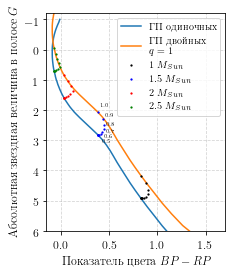

In [13]:
fig, ax = plt.subplots(figsize=(3.2,4))

plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

ax.scatter (stars_1['BP-RP, mag'],
            stars_1['G, mag'],
            c='black', s=1.5, label=r"$1 \ M_{Sun}$", zorder=100)

ax.scatter (stars_15['BP-RP, mag'],
            stars_15['G, mag'],
            c='blue', s=1.5, label=r"$1.5 \ M_{Sun}$", zorder=100)

ax.scatter (stars_2['BP-RP, mag'],
            stars_2['G, mag'],
            c='red', s=1.5, label=r"$2 \ M_{Sun}$", zorder=10)

ax.scatter (stars_25['BP-RP, mag'],
            stars_25['G, mag'],
            c='green', s=1.5, label=r"$2.5 \ M_{Sun}$", zorder=5)

l1, = ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'], label='ГП одиночных')
l2, = ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'] - 2.5*np.log10(2), 
        label='ГП двойных \n $q=1$')

ax.grid(c='#aaaaaa', ls='--', alpha=0.5)

plt.xlabel(r'Показатель цвета $BP-RP$')
plt.ylabel(r'Абсолютная звездная величина в полосе $G$', labelpad=4)

#plt.yticks(np.arange(0.8,1.7, step=0.2))
ax.set_xticks(np.arange(-0.5, 2, step=0.5))
ax.set_xlim(-0.15, 1.7)

ax.set_ylim(-1.2,6)

ax.invert_yaxis()
ax.legend(loc='upper right', fontsize='small')
#ax.legend(loc='upper right', fontsize='small', labels=['3','4'])

for i in range(5, len(stars_2)):
    q = stars_15.loc[i,'q']
    ax.annotate("%.1f" % q, (stars_15.loc[i, 'BP-RP, mag']+0.02, stars_15.loc[i, 'G, mag'] + (0.8-q)*0.9),size=5)
ax.tick_params(axis='both', which='major')

plt.savefig(MODEL_DIRECTORY / 'plots' / (f"model_binaries_track.pdf"), bbox_inches = 'tight')


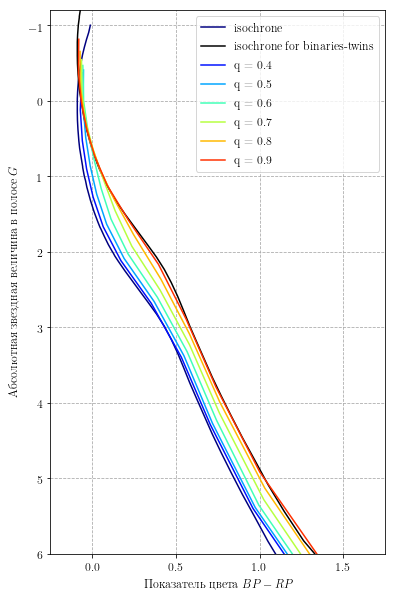

In [20]:
fig, ax = plt.subplots(figsize=(6,10))
colors = plab.cm.jet(np.linspace(0,1,8))

ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'], label='isochrone', color=colors[0])
ax.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['Gmag'] - 2.5*np.log10(2), 
        label='isochrone for binaries-twins', color='black')

ax.plot(stars_q04['BP-RP, mag'], stars_q04['G, mag'], label='q = 0.4', color=colors[1])
ax.plot(stars_q05['BP-RP, mag'], stars_q05['G, mag'], label='q = 0.5', color=colors[2])
ax.plot(stars_q06['BP-RP, mag'], stars_q06['G, mag'], label='q = 0.6', color=colors[3])
ax.plot(stars_q07['BP-RP, mag'], stars_q07['G, mag'], label='q = 0.7', color=colors[4])
ax.plot(stars_q08['BP-RP, mag'], stars_q08['G, mag'], label='q = 0.8', color=colors[5])
ax.plot(stars_q09['BP-RP, mag'], stars_q09['G, mag'], label='q = 0.9', color=colors[6])

ax.grid(c='#aaaaaa', ls='--')

plt.xlabel('Показатель цвета $BP-RP$')
plt.ylabel('Абсолютная звездная величина в полосе $G$', labelpad=8)

#plt.yticks(np.arange(0.8,1.7, step=0.2))
ax.set_xticks(np.arange(-0.5, 1.75, step=0.5))
ax.set_xlim(-0.25, 1.75)

ax.set_ylim(-1.2,6)

ax.invert_yaxis()

ax.tick_params(axis='both', which='major')
ax.legend(loc='upper right')
# plt.savefig(MODEL_DIRECTORY / (f"model_binaries_track.pdf"), bbox_inches = 'tight')



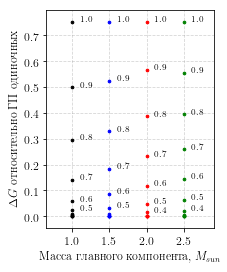

In [22]:
fig, ax = plt.subplots(figsize=(3,4))

ax.scatter ([1]*len(stars_1['G, mag']),
            stars_1['G, mag'].max() - stars_1['G, mag'],
            c='black', s=7, zorder=100)

ax.scatter ([1.5]*len(stars_15['G, mag']),
            stars_15['G, mag'].max() - stars_15['G, mag'],
            c='blue', s=7, zorder=100)

ax.scatter ([2]*len(stars_2['G, mag']),
            stars_2['G, mag'].max() - stars_2['G, mag'],
            c='red', s=7, zorder=100)

ax.scatter ([2.5]*len(stars_25['G, mag']),
            stars_25['G, mag'].max() - stars_25['G, mag'],
            c='green', s=7, zorder=100)

ax.grid(c='#aaaaaa', ls='--', alpha=0.5)

plt.xlabel('Масса главного компонента, $M_{sun}$')
plt.ylabel('$\Delta G$ относительно ГП одиночных', labelpad=4)

ax.set_xticks(np.arange(0, 3, 0.5))
ax.set_xlim(0.65, 2.9)

for i in range(4, len(stars_2)):
    q = stars_2.loc[i,'q']
    ax.annotate("%.1f" % q, (2.1, stars_2.loc[0, 'G, mag'] - stars_2.loc[i,'G, mag']), size=9)
    
for i in range(4, len(stars_2)):
    q = stars_25.loc[i,'q']
    ax.annotate("%.1f" % q, (2.6, stars_25.loc[0, 'G, mag'] - stars_25.loc[i,'G, mag']), size=9)
    
for i in range(5, len(stars_2)):
    q = stars_1.loc[i,'q']
    ax.annotate("%.1f" % q, (1.1, stars_1.loc[0, 'G, mag'] - stars_1.loc[i,'G, mag']), size=9)
    
for i in range(5, len(stars_15)):
    q = stars_15.loc[i,'q']
    ax.annotate("%.1f" % q, (1.6, (stars_15.loc[0, 'G, mag'] - stars_15.loc[i,'G, mag'])), size=9)

ax.tick_params(axis='both', which='major')
plt.savefig(MODEL_DIRECTORY / 'plots' /(f"model_binaries_track_onlyG.pdf"), bbox_inches = 'tight')

Text(0, 0.5, 'Абсолютная звездная величина в полосе $G$')

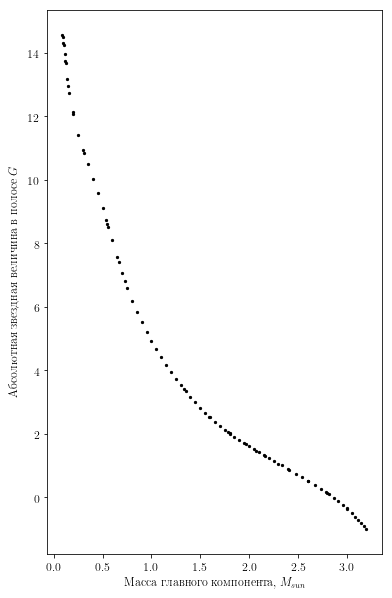

In [23]:
fig, ax = plt.subplots(figsize=(6,10))

ax.scatter (isochrone['Mini'], isochrone['Gmag'], c='black', s=5, zorder=100)
plt.xlabel('Масса главного компонента, $M_{sun}$')
plt.ylabel('Абсолютная звездная величина в полосе $G$', labelpad=8)